# Floquet Formalism

Author: C. Staufenbiel, 2022

Inspirations taken from the [floquet notebook](https://github.com/qutip/qutip-notebooks/blob/master/examples/floquet-dynamics.ipynb) by P.D. Nation and J.R. Johannson, and the [qutip documentation](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-floquet.html).

### Introduction

In the [floquet_solver notebook](011_floquet_solver.md) we introduced the two functions to solve the Schrödinger and Master equation using the Floquet formalism (i.e. `fsesolve` and  `fmmesolve`). In this notebook, we will work with on `FloquetBasis` class which is used by solvers. In particular, we will focus on the Floquet modes and quasi-energies.

More information on the implementation of the Floquet Formalism in QuTiP can be found in the [documentation](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-floquet.html).

### Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, expect, FloquetBasis,
                   num, plot_wigner, ket, sesolve, sigmax, sigmaz)

### System setup
For consistency with the documentation we consider the driven system with the following Hamiltonian: 

$$ H = - \frac{\Delta}{2} \sigma_x - \frac{\epsilon_0}{2} \sigma_z + \frac{A}{2} \sigma_x sin(\omega t) $$

In [2]:
# Constants
delta = 0.2 * 2 * np.pi
eps0 = 1 * 2 * np.pi
A = 2.5 * 2 * np.pi
omega = 1.0 * 2 * np.pi
T = 2 * np.pi / omega

# Hamiltonian
H = [
    -delta / 2.0 * sigmax() - eps0 / 2.0 * sigmaz(),
    [A / 2 * sigmax(), "sin({w}*t)".format(w=omega)],
]

### Floquet modes and quasienergies
For periodic Hamiltonians the solution to the Schrödinger equation can be represented by the Floquet modes $\phi_\alpha(t)$ and the quasienergies $\epsilon_\alpha$. We can obtain these for the initial time $t=0$ by using the class `FloquetBasis(H, T)` and its method `.mode(t=0)`.

For example, we can display the first Floquet mode at $t=0$ using a Wigner distribution:

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:420: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


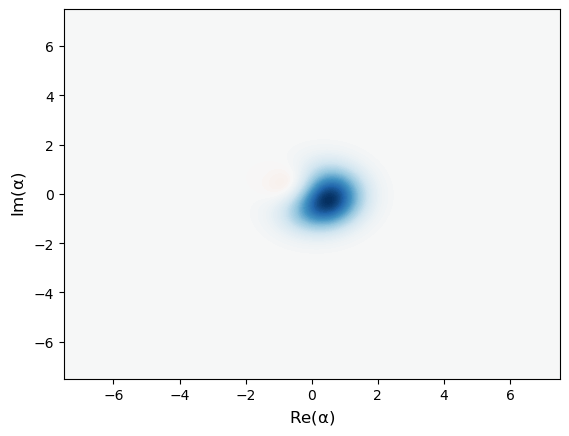

In [3]:
fbasis = FloquetBasis(H, T)
f_modes_t0 = fbasis.mode(t=0)
plot_wigner(f_modes_t0[0]);

For the system defined above there are two eigenenergies. We can plot these two quasienergies for varying strength of driving $A$.

We access the eigenenergies via the `.e_quasi` attribute of `FloquetBasis` while passing `sort=True` to ensure that the energies are sorted from lowest to highest:

In [4]:
A_list = np.linspace(1.0 * omega, 4.5 * omega, 20)
quasienergies1, quasienergies2 = [], []
for A_tmp in A_list:
    # temporary Hamiltonian
    H_tmp = [
        -delta / 2.0 * sigmax() - eps0 / 2.0 * sigmaz(),
        [A_tmp / 2 * sigmax(), "sin({w}*t)".format(w=omega)],
    ]
    # floquet modes and quasienergies
    e1, e2 = FloquetBasis(H_tmp, T, sort=True).e_quasi
    quasienergies1.append(e1), quasienergies2.append(e2)

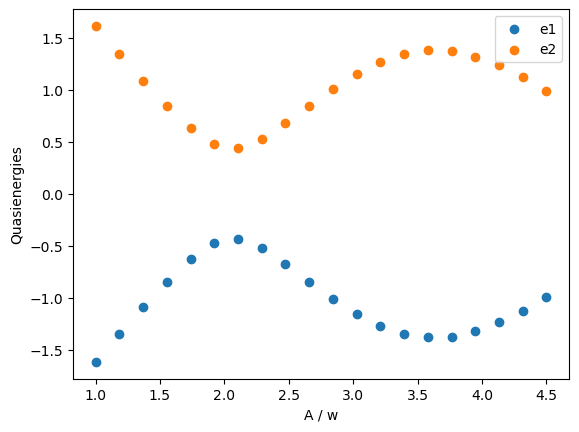

In [5]:
plt.scatter(A_list / omega, quasienergies1, label="e1")
plt.scatter(A_list / omega, quasienergies2, label="e2")
plt.xlabel("A / w"), plt.ylabel("Quasienergies")
plt.legend();

### Time evolution with Floquet mode
To calculate the time evolution of a random initial state $\psi(0)$, we have to decompose the state in the Floquet basis (formed by the Floquet modes):

$$ \psi(0) = \sum_\alpha c_\alpha \phi_\alpha(0) $$

The $c_\alpha$ are calculated using the `.to_floquet_basis` method:

In [6]:
# Define an initial state:
psi0 = ket("0") + ket("1")
psi0 = psi0.unit()

# Decompose the initial state into its components in the Floquet modes:
f_coeff = fbasis.to_floquet_basis(psi0, t=0)
f_coeff

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.91292459+0.13897063j]
 [0.35769125+0.13897063j]]

The Floquet mode $\phi_\alpha(t)$ for later times $t>0$ can be calculated using the wave function propagator $U(t,0)$ by:

$$ \phi_\alpha(t) = exp(-i\epsilon_\alpha t / \hbar) \, U(t,0) \, \phi_\alpha(0) $$

In QuTiP this is done by the `FloquetBasis.mode(t=t)` function. Here we propagate the initial state to the state at $t=1$:

In [7]:
t = 1.0
f_modes_t1 = fbasis.mode(t=t)
f_modes_t1

[Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.89846107+0.j        ]
  [0.39260926-0.19653415j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.39260926-0.19653415j]
  [ 0.89846107+0.j        ]]]

The propagated Floquet modes $\phi_\alpha(t)$ can be combined to describe the full system state $\psi(t)$ at the time `t`.

The method `.from_floquet_basis(f_coeff, t)` is used to calculate the new state in this manner:

In [8]:
psi_t = fbasis.from_floquet_basis(f_coeff, t)
psi_t

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.37935158+0.60194095j]
 [0.70145307+0.04150972j]]

### Precomputing and reusing the Floquet modes of one period

The Floquet modes have the same periodicity as the Hamiltonian: 

$$ \phi_\alpha(t + T) = \phi_\alpha(t) $$

Hence it is enough to evaluate the modes at times $t \in [0,T]$. From these modes we can extrapolate the system state $\psi(t)$ for any time $t$. 

The class `FloquetBasis` allows one to calculate the Floquet mode propagators for multiple times in the first period by specifying a list of times to `precompute`:

In [9]:
tlist = np.linspace(0, T, 50)
fbasis = FloquetBasis(H, T, precompute=tlist)

We can now again use `FloquetBasis.from_floquet_basis(...)` to build the wavefunction $\psi(t)$, but now the Floquet modes at each $t$ have been precomputed.

Below, we calculate the expectation value for the number operator in the first period using the precomputed modes:

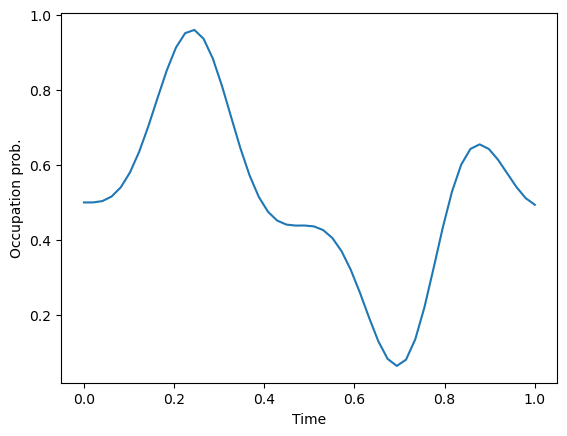

In [10]:
p_ex_period = []
for t in tlist:
    psi_t = fbasis.from_floquet_basis(f_coeff, t)
    p_ex_period.append(expect(num(2), psi_t))

plt.plot(tlist, p_ex_period)
plt.ylabel("Occupation prob."), plt.xlabel("Time");

The pre-computed modes for the first period can be used by the `FloquetBasis` class to calculate Floquet modes and states in later periods too. However if a time $t'$ is not exactly $t' = t + nT$ (where $t$ is a time used in the pre-computation) the Floquet modes for time $t'$ will be computed and one of the precomputed modes will be forgotten.

Under the hood, `FloquetBasis` uses `qutip.Propagator` to manage the precomputed modes. The documentation for `Propagator` describes the details. The propagator is directly available as `FloquetBasis.U` if needed.

Below we show how this works in practice over the first ten periods. If the times in `tlist` correspond to those in the first period that we have already been precomputed, calculating the expecations in later periods should be fast:

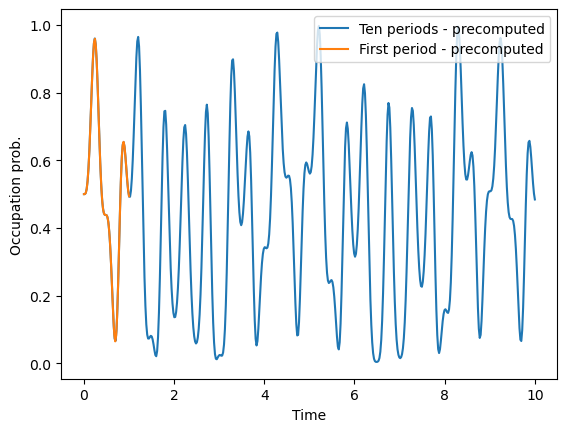

In [11]:
p_ex = []
tlist_10_periods = np.linspace(0, 10 * T, 10 * len(tlist))
for t in tlist_10_periods:
    psi_t = fbasis.from_floquet_basis(f_coeff, t)
    p_ex.append(expect(num(2), psi_t))

# Plot the occupation Probability
plt.plot(tlist_10_periods, p_ex, label="Ten periods - precomputed")
plt.plot(tlist, p_ex_period, label="First period - precomputed")
plt.legend(loc="upper right")
plt.xlabel("Time"), plt.ylabel("Occupation prob.");

### About

In [12]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [13]:
# compute prediction using sesolve
res_sesolve = sesolve(H, psi0, tlist_10_periods, [num(2)])
assert np.allclose(res_sesolve.expect[0], p_ex, atol=0.15)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
